# Richards equation

In this tutorial we present how to solve a Richards equation with [PyGeoN](https://github.com/compgeo-mox/pygeon).  The unkwons are the velocity $q$ and the pressure $p$.

Let $\Omega=(0,2)\times(0,3)$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Given 
$k$ the matrix permeability, we want to solve the following problem: find $({q}, \psi)$ such that
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi) {q} + \nabla \psi = -\nabla z\\
\partial_t \theta (\psi) + \nabla \cdot {q} = 0
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
with boundary conditions:

$$
\psi(t,x,z)=
\left\{
\begin{array}{ll}
\begin{array}{l} 
-2+2.2 \frac{t}{\Delta t_D}, \text{ on } \Gamma_{D_1}, t\leq\Delta t_D\\
0.2, \text{ on } \Gamma_{D_1}, t>\Delta t_D\\
1-z, \text{ on } \Gamma_{D_2}
\end{array}
\end{array}
\right., \qquad \nu \cdot q = 0 \text{ on } \Gamma_N \qquad \psi(0,x,z) = 1-z \text{ on } \Omega$$
and
$$
\Gamma_{D_1} = \left\{ (x,z) \in \partial \Omega \:|\: x \in [0,1] \wedge z=3  \right\},\\
\Gamma_{D_2} = \left\{ (x,z) \in \partial \Omega \:|\: x = 2 \wedge z \in [0,1]  \right\},\\
\Gamma_{D} = \Gamma_{D_1} \cup \Gamma_{D_2},\\
\Gamma_{N} = \partial \Omega \setminus \Gamma_D
$$

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

### Import and parameters

In [1]:
import shutil
import os

import numpy as np
import scipy.sparse as sps
from scipy.sparse import linalg
import sympy as sp

import porepy as pp
import pygeon as pg

from math import ceil, floor, log10, exp

import matplotlib.pyplot as plt

In [2]:
K = 50
N = 20
num_steps = 100

eps_psi_abs = 1e-6
eps_psi_rel = 1e-6

domain_tolerance = 1 / (10 * N)
beta_q   = 0
beta_psi = 0

output_directory = 'output_evolutionary'

In [3]:
rho = 1000
g = pp.GRAVITY_ACCELERATION

theta_s = 0.396
theta_r = 0.131

alpha = 0.423

n = 2.06
K_s = 4.96e-2

dt_D = 1/16
T    = 3/16

In [4]:
theta_s = 0.446
theta_r = 0.0

alpha = 0.152

n = 1.17
K_s = 8.2e-4

dt_D = 1
T    = 3

In [5]:
h_s = 0
theta_m = theta_s
m = 1 - 1/n
L = 0.5

In [6]:
dt   = (T-0)/num_steps

### $\theta$ and $k$, with their derivatives w.r.t. $\psi$

In [7]:
psi_var = sp.Symbol('psi', negative=True)
theta_expression = theta_r + (theta_s - theta_r) / (1 + (-alpha * psi_var) ** n) ** m

theta_negative_func = sp.lambdify(psi_var, theta_expression, 'numpy')

In [8]:
effective_saturation = (theta_expression - theta_r) / (theta_s - theta_r)

hydraulic_conductivity_expression = K_s * (effective_saturation ** L) * ( 1 - (1 - effective_saturation ** (1 / m)) ** m ) ** 2
hydraulic_conductivity_negative_func = sp.lambdify(psi_var, hydraulic_conductivity_expression, 'numpy')

In [9]:
def theta(psi):
    mask = psi < h_s

    res = np.ones_like(psi) * theta_s
    res[mask] = theta_negative_func(psi[mask])

    return res

In [10]:
def hydraulic_conductivity_coefficient(psi):
    mask = psi < h_s

    res = np.ones_like(psi) * K_s
    res[mask] = hydraulic_conductivity_negative_func(psi[mask])

    return res

In [11]:
derivative_theta_negative_func = sp.lambdify(psi_var, sp.diff(theta_expression, psi_var), 'numpy')
derivative_hydraulic_conductivity_negative_func = sp.lambdify(psi_var, sp.diff(hydraulic_conductivity_expression, psi_var), 'numpy')
derivative_inverse_hydraulic_conductivity_negative_func = sp.lambdify(psi_var, sp.diff(1 / hydraulic_conductivity_expression, psi_var), 'numpy')

In [12]:
def derivative_theta(psi):
    mask = psi < h_s
    res = np.zeros_like(psi)

    res[mask] = derivative_theta_negative_func(psi[mask])

    return res

In [13]:
def derivative_hydraulic_conductivity_coefficient(psi):
    mask = psi < h_s
    res = np.zeros_like(psi)

    res[mask] = derivative_hydraulic_conductivity_negative_func(psi[mask])

    return res

In [14]:
def derivative_inverse_hydraulic_conductivity_coefficient(psi):
    mask = psi < h_s
    res = np.zeros_like(psi)

    res[mask] = derivative_inverse_hydraulic_conductivity_negative_func(psi[mask])

    return res

In [15]:
def quick_plot():
    psi_val = np.linspace(-2, 1, 100)

    theta_max = theta_s
    theta_min = theta_r

    _, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))

    ax1.plot(psi_val, theta(psi_val))
    ax1.plot(psi_val, theta_max * np.ones_like(psi_val), linestyle="--", color="red")
    ax1.plot(
        psi_val,
        theta_min * np.ones_like(psi_val),
        linestyle="--",
        color="green",
    )
    ax1.set_title("theta")

    ax2.plot(psi_val, hydraulic_conductivity_coefficient(psi_val))
    ax2.set_title("K")

    ax3.plot(psi_val, 1 / hydraulic_conductivity_coefficient(psi_val))
    ax3.set_title("K^-1")

    ax4.plot(psi_val, derivative_theta(psi_val))
    ax4.set_title("d theta / d psi")

    ax5.plot(psi_val, derivative_hydraulic_conductivity_coefficient(psi_val))
    ax5.set_title("d (K) / d psi")

    ax6.plot(psi_val, derivative_inverse_hydraulic_conductivity_coefficient(psi_val))
    ax6.set_title("d (K^-1) / d psi")


    plt.show()

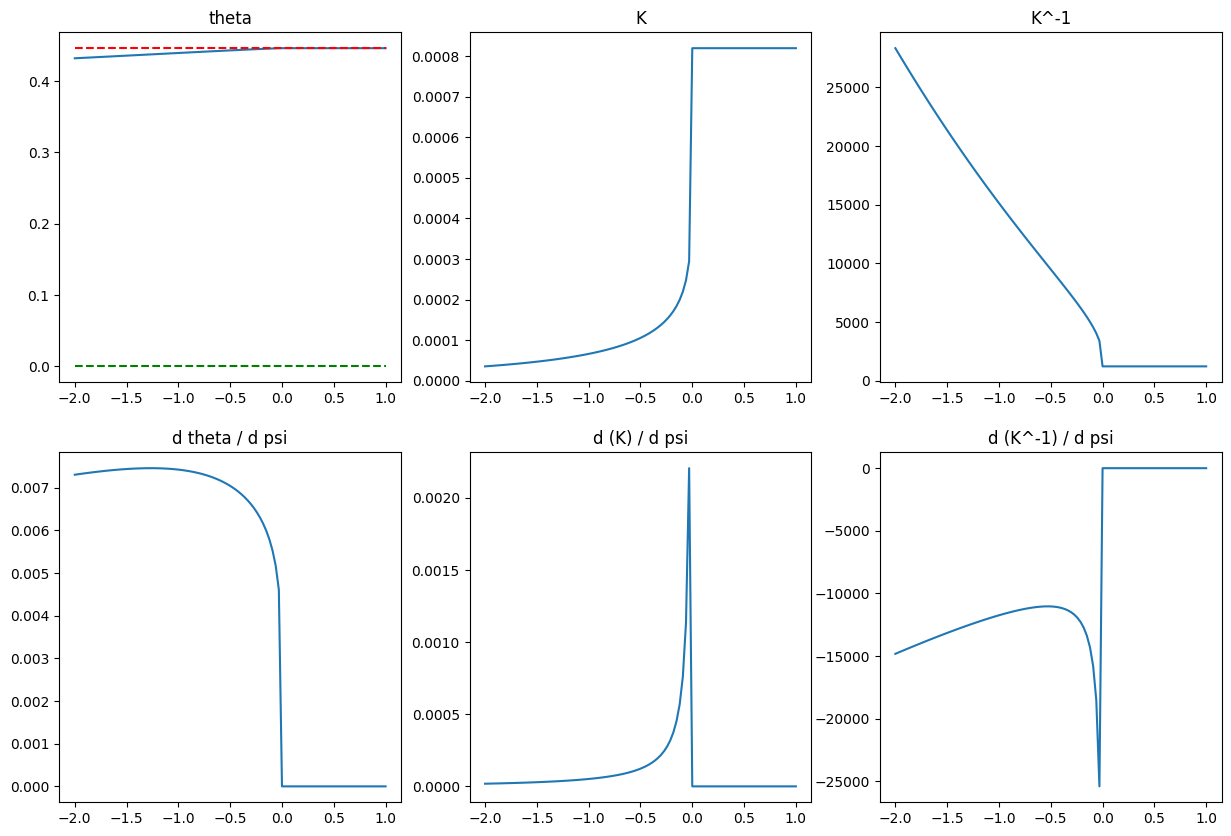

In [16]:
quick_plot()

### Domain preparation

In [17]:
subdomain = pp.StructuredTriangleGrid([2*N, 3*N], [2,3])
# convert the grid into a mixed-dimensional grid
mdg = pp.meshing.subdomains_to_mdg([subdomain])

In [18]:
key = "flow"

bc_value = []
bc_essential = []
initial_pressure = []

gravity = []

RT0 = pg.RT0(key)
P0  = pg.PwConstants(key)

In [19]:
def g_func(x): 
    return np.array([0, -1, -1])

In [20]:
def initial_pressure_func(x): 
    return 1-x[1]

In [21]:
for subdomain, data in mdg.subdomains(return_data=True):
    g_proj = RT0.interpolate(subdomain, g_func)
    gravity.append(RT0.assemble_mass_matrix(subdomain) @ g_proj)
    
    initial_pressure.append(P0.interpolate(subdomain, initial_pressure_func))
        
    # with the following steps we identify the portions of the boundary
    # to impose the boundary conditions
    boundary_faces_indexes = subdomain.get_boundary_faces()

    gamma_d1 = np.logical_and(subdomain.face_centers[0, :] > 0-domain_tolerance, np.logical_and(subdomain.face_centers[0, :] < 1+domain_tolerance, subdomain.face_centers[1, :] > 3-domain_tolerance))
    gamma_d2 = np.logical_and(subdomain.face_centers[0, :] > 2-domain_tolerance, np.logical_and(subdomain.face_centers[1, :] > 0-domain_tolerance, subdomain.face_centers[1, :] < 1+domain_tolerance))

    gamma_d  = np.logical_or(gamma_d1, gamma_d2)
    
    gamma_n  = gamma_d.copy()
    gamma_n[boundary_faces_indexes] = np.logical_not(gamma_n[boundary_faces_indexes])
    

    pp.initialize_data(subdomain, data, key, {
        "second_order_tensor": pp.SecondOrderTensor(np.ones(subdomain.num_cells)),
    })
    
    def bc_gamma_d(x, t):
        if   x[0] > 2-domain_tolerance and x[1] > 0-domain_tolerance and x[1] < 1+domain_tolerance:
            res =  1 - x[1]
        elif x[1] > 3-domain_tolerance and x[0] > 0-domain_tolerance and x[0] < 1+domain_tolerance:
            res = min( 0.2, -2 + 2.2 * t / dt_D )
        else:
            res = 0
        
        return res

    bc_value.append(lambda t: - RT0.assemble_nat_bc(subdomain, lambda x: bc_gamma_d(x,t), gamma_d))

    essential_pressure_dofs = np.zeros(P0.ndof(subdomain), dtype=bool)
    bc_essential.append(np.hstack((gamma_n, essential_pressure_dofs)))

### Method

A quick recap:
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi) {q} + \nabla \psi = -\nabla z\\
\partial_t \theta (\psi) + \nabla \cdot {q} = 0
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
becames, with the time discretization:

$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi^{n+1}_k) {q^{n+1}_{k+1}} + \nabla \psi^{n+1}_{k+1} = -\nabla z\\
\frac{\partial \theta(\psi_k^{n+1})}{\partial \psi} \frac{\psi_{k+1}^{n+1}}{\Delta t} + \nabla \cdot {q^{n+1}} = \frac{\partial \theta(\psi_k^{n+1})}{\partial \psi} \frac{\psi_{k}^{n+1}}{\Delta t} + \frac{\theta (\psi^{n}) - \theta (\psi^{n+1}_k)}{\Delta t} 
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$

In [22]:
B = -pg.cell_mass(mdg) @ pg.div(mdg)

# get the degrees of freedom for each variable
dof_p, dof_q = B.shape
dof_psi = dof_p

In [23]:
proj_q   = RT0.eval_at_cell_centers(subdomain)
proj_psi =  P0.eval_at_cell_centers(subdomain)


def export_step(save, current_sol, step) -> None:
    q   = current_sol[:dof_q]
    psi = current_sol[-dof_psi:]

    ins = list()

    ins.append((subdomain, "cell_q", ( proj_q @ q).reshape((3, -1), order="F")))
    ins.append((subdomain, "cell_p", proj_psi @ psi))
    
    save.write_vtu(ins, time_step=step)

In [24]:
def project_array_to_P0(val):
    return val * subdomain.cell_volumes

In [25]:
def picard(sol_n, t_n_1, prev=None, iters=K, debug=False):
    if prev == None:
        prev = sol_n.copy()

    Mass_q   = RT0.assemble_mass_matrix(subdomain)
    Mass_psi =  P0.assemble_mass_matrix(subdomain)

    # assemble the right-hand side
    fixed_rhs = np.zeros(dof_psi + dof_q)

    # Theta^n
    fixed_rhs[-dof_psi:] += Mass_psi @ project_array_to_P0(theta(proj_psi @ sol_n[-dof_psi:])) / dt

    # Natural BCs
    fixed_rhs[:dof_q] += np.hstack(list(cond(t_n_1) for cond in bc_value))

    # Gravity
    fixed_rhs[:dof_q] += np.hstack(gravity)

    if debug:
        save_debug = pp.Exporter(mdg, "sol_" + str(t_n_1), folder_name=output_directory + "/debug")
        export_step(save_debug, prev, 0)

    print('Time ' + str(round(t_n_1, 5)))

    for k in range(iters):
        psi = prev[-dof_psi:]
        q   = prev[:dof_q]

        rhs = None
        rhs = fixed_rhs.copy()

        # Theta^{n+1}_k
        rhs[-dof_psi:] -= Mass_psi @ project_array_to_P0(theta(proj_psi @ psi)) / dt

        # Dev Thetha^{n+1}_k
        rhs[-dof_psi:] += Mass_psi @ np.diag(derivative_theta(proj_psi @ psi)) @ psi / dt

        rhs[-dof_psi:] += beta_psi * Mass_psi @ psi
        rhs[:dof_q]    += beta_q   * Mass_q   @ q


        data[pp.PARAMETERS].update({"second_order_tensor": pp.SecondOrderTensor(hydraulic_conductivity_coefficient(proj_psi @ psi))})

        # construct the local matrices
        M_k_n_1 = None
        M_k_n_1 = pg.face_mass(mdg)

        
        spp = sps.bmat([[M_k_n_1 + beta_q * Mass_q,                                                                             B.T], 
                        [-B,                        beta_psi * Mass_psi + Mass_psi @ np.diag(derivative_theta(proj_psi @ psi)) / dt]], format="csc")

        
        # solve the problem
        ls = None
        ls = pg.LinearSystem(spp, rhs)
        ls.flag_ess_bc(np.hstack(bc_essential), np.zeros(dof_q + dof_psi))
    
        current = None
        current = ls.solve()

        if debug:
            export_step(save_debug, current, k+1)


        abs_err_psi  = np.sqrt(np.sum(np.power(current[-dof_psi:] - psi, 2)))
        abs_err_prev = np.sqrt(np.sum(np.power(psi, 2)))


        print('Iteration #' + format(k+1, '0' + str(ceil(log10(iters)) + 1) + 'd') 
              + ', error L2 relative psi: ' + format(abs_err_psi, str(5 + ceil(log10(1 / eps_psi_abs)) + 4) + '.' + str(ceil(log10(1 / eps_psi_abs)) + 4) + 'f') )

        if abs_err_psi < eps_psi_abs + eps_psi_rel * abs_err_prev:
            print('')
            return current
        else:
            prev = current
    return current

In [26]:
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

In [27]:
# assemble initial solution
initial_solution = np.zeros(dof_q + dof_psi)
initial_solution[-dof_psi:] += np.hstack(initial_pressure)

In [28]:
sol = [initial_solution]
save = pp.Exporter(mdg, "sol", folder_name=output_directory)
export_step(save, sol[-1], 0)

# Time Loop
for step in range(1, ceil(T/dt)+1):
    sol.append( picard(sol[-1], step * dt, debug=True) )
    export_step(save, sol[-1], step)

save.write_pvd(np.array(range(0, ceil(T/dt)+1)) * dt)

Time 0.03
Iteration #001, error L2 relative psi:    0.0025136101
Iteration #002, error L2 relative psi:    0.0000014693
Iteration #003, error L2 relative psi:    0.0000000000

Time 0.06
Iteration #001, error L2 relative psi:    0.0029483320
Iteration #002, error L2 relative psi:    0.0000033906
Iteration #003, error L2 relative psi:    0.0000000000

Time 0.09
Iteration #001, error L2 relative psi:    0.0030428928
Iteration #002, error L2 relative psi:    0.0000030483
Iteration #003, error L2 relative psi:    0.0000000000

Time 0.12
Iteration #001, error L2 relative psi:    0.0030634158
Iteration #002, error L2 relative psi:    0.0000043200
Iteration #003, error L2 relative psi:    0.0000000000

Time 0.15
Iteration #001, error L2 relative psi:    0.0030675837
Iteration #002, error L2 relative psi:    0.0000044816
Iteration #003, error L2 relative psi:    0.0000000000

Time 0.18
Iteration #001, error L2 relative psi:    0.0030695444
Iteration #002, error L2 relative psi:    0.0000038351
